In [1]:
import argparse
import h5py
import os
import sys
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras.models import model_from_json
import keras.backend as K

sys.path.insert(0, os.path.abspath('../../Evolutron'))
from evolutron.engine import DeepTrainer
from evolutron.tools import load_dataset, Handle, shape, data_it
from evolutron.motifs import motif_extraction
from evolutron.networks import custom_layers

Using TensorFlow backend.


In [198]:
# First load model architecture
filename = '../models/file/100_30_5_1_1_DeepCoFAM_test.model'
hf = h5py.File(filename)
model_config = hf.attrs['model_config'].decode('utf8')
hf.close()

In [199]:
net = DeepTrainer(model_from_json(model_config, custom_objects=custom_layers))
# Then load model parameters
net.load_all_param_values(filename)

In [203]:
handle = Handle.from_filename(filename.strip('..'))
data_id = 'dnabind'
x_data, y_data = load_dataset(data_id, padded=True, max_aa=1227)

Dataset size: 11036
Dataset size: 11036


In [154]:
conv_params = net.get_conv_param_values()

In [192]:
params = net.get_all_param_values()

In [197]:
params[2][0,:]

array([ 1.21970296,  0.29077703,  1.14720714, -0.35345823, -1.5782088 ,
       -0.04750178, -0.63572651, -0.19425811, -0.47411343,  0.87977314,
        0.06720995,  0.08947103, -0.2136196 , -0.33669823, -1.84463942,
        0.21478952, -1.58685195,  0.07129087, -0.15567534, -0.01074746,
       -0.45904186, -0.33803239,  0.56247592,  0.61366129, -1.87909293], dtype=float32)

In [155]:
test_filter = conv_params[0][0][:,:,8]

In [22]:
from evolutron.tools import aa2hot, hot2aa

In [41]:
seq = hot2aa(x_data[0])

In [204]:
conv_layers = net.get_conv_layers()

conv_layer = conv_layers[0]

conv_scores = conv_layer.output  # Changed from -1 to 0

boolean_mask = K.any(K.not_equal(net.input, 0.0), axis=-1, keepdims=True)
conv_scores = conv_scores * K.cast(boolean_mask, K.floatx())

# Compile function that spits out the outputs of the correct convolutional layer
motif_fun = K.function([net.input], [conv_scores])

In [205]:
max_seq_scores = []
for x_part in data_it(x_data, 5000):
    seq_scores = np.squeeze(motif_fun([x_part]), 0) 

    # For every filter, keep max and argmax for each input protein
    max_seq_scores.append(np.asarray([np.vstack((np.max(x, 0), np.argmax(x, 0))) for x in seq_scores]))

    del seq_scores
max_seq_scores = np.concatenate(max_seq_scores).transpose((2, 0, 1))

In [222]:
# noinspection PyUnusedLocal
filters = conv_layer.filters
kernel_size = conv_layer.kernel_size[0]
depth = 0
vf= kernel_size + depth * (kernel_size - 1)
matches = [[] for i in range(filters)]
match_sc = [[] for i in range(filters)]
for k, filt in enumerate(max_seq_scores):
    seq_mean = np.mean(filt[:, 0])
    seq_std = np.std(filt[:, 0])
    for i, seq in enumerate(filt):
        if seq[0] > 0:
            j = int(seq[1])
            if j + vf - 1 < x_unpad[i].shape[0]:
                matches[k].append(hot2aa(x_unpad[i][j:j + vf, :]))
                match_sc[k].append(seq[0])

In [223]:
len(matches[8])

1174

In [175]:
l = net.get_conv_layers()[0]

In [176]:
l.get_weights()[1]

array([-1.99557889, -2.42553329, -2.22050738, -2.44582701, -2.38901258,
       -2.23886847, -1.95324802, -1.91876709, -1.54722738, -1.6677376 ,
       -1.91759849, -1.84682846, -1.74667966, -2.09375167, -2.00723553,
       -2.41535807, -1.46805716, -1.93608332, -2.20722628, -1.85157752,
       -2.25992513, -1.836676  , -1.72485924, -1.80262804, -2.39472389], dtype=float32)

In [226]:
sorted(list(zip(matches[1], match_sc[1])), key=lambda x: x[1])

[('ELEDQFGQISDTTMEEKIPFLQMLQCIEHP', 0.0047538876533508301),
 ('EWVQIALDLTSGLSSKDRFERLLSTIRNAL', 0.0048778057098388672),
 ('LLERQILAADDVGDAGQPDGAGPTDQRNLL', 0.0054057836532592773),
 ('YIRLAKEDEIRYHNEMKSWEEQMIEAGRKD', 0.0060825347900390625),
 ('VLSRSRAKTVTNGNSQHSEEESSDEEHPND', 0.0069327354431152344),
 ('EHGDPGDTWKDYCTLVTIAKSLLDLNKYRP', 0.0087109804153442383),
 ('AGMRRECVQKRRSNKKIPKKHMNMLREDQI', 0.0099925994873046875),
 ('LEKEAIIIGVGTRVEIWSNVEWEKYNSDDN', 0.010808706283569336),
 ('AWLEEAEAAYREKNGKPDLFNGNERKRKRT', 0.011530876159667969),
 ('MASPSKAKEVFSSDEEGPAAGAEEHHKVKV', 0.011677742004394531),
 ('MLEGHESYDTENFYFREIRKNLQEVDFQWK', 0.014673233032226562),
 ('KGKVGRPTASKASKEKTPSPKEEDEEPESP', 0.02171015739440918),
 ('KGKVGRPTASKASKEKTPSPKEEDEEPESP', 0.02171015739440918),
 ('AGDSPDSGTHRGSMGRSGSTQFASTPIGGT', 0.022962212562561035),
 ('ELSCKWIDEAQLSRPKKSCDRTFSTMHELV', 0.023195028305053711),
 ('HLDDPKVALLIFSSGKLVVTGAKSVQDIER', 0.036137700080871582),
 ('HLDDPKVALLIFSSGKLVVTGAKSVQDIER', 0.0361377000808

In [146]:
max_seq_scores.shape

(25, 11036, 2)

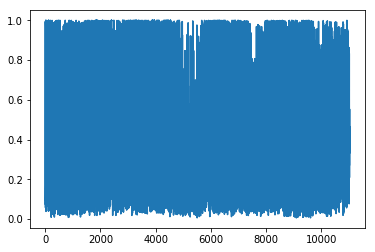

In [187]:
ax = plt.plot(max_seq_scores[5,:,0])

In [219]:
import weblogolib as wl
from corebio.seq_io import SeqList
seqs = SeqList(matches[1])
seqs.alphabet = wl.std_alphabets['protein']
data = wl.LogoData.from_seqs(seqs=seqs)

In [220]:
options = wl.LogoOptions()
options.color_scheme = wl.std_color_schemes["chemistry"]
my_format = wl.LogoFormat(data, options)
my_png = wl.png_formatter(data, my_format)
foo = open("test.png", "wb")
foo.write(my_png)
foo.close()

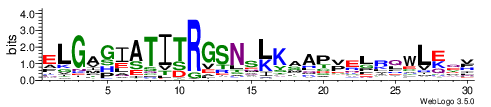

In [221]:
from IPython.display import Image
Image('test.png')

In [ ]:
handle = Handle.from_filename(filename)



data_id = handle.dataset

x_data, y_data = load_dataset(data_id, padded=True)

In [ ]:
conv_layers = net.get_conv_layers()

conv_layer = conv_layers[0]

conv_scores = conv_layer.output  # Changed from -1 to 0

boolean_mask = K.any(K.not_equal(net.input, 0.0), axis=-1, keepdims=True)
conv_scores = conv_scores * K.cast(boolean_mask, K.floatx())

# Compile function that spits out the outputs of the correct convolutional layer
motif_fun = K.function([net.input], [conv_scores])

In [ ]:
filters = conv_layer.filters
kernel_size = conv_layer.kernel_size[0]
depth = 0
vf= kernel_size + depth * (kernel_size - 1)

In [ ]:
import numpy as np
max_seq_scores = []
for x_part in data_it(x_data, 5000):
    seq_scores = np.squeeze(motif_fun([x_part]), 0) 

    # For every filter, keep max and argmax for each input protein
    max_seq_scores.append(np.asarray([np.vstack((np.max(x, 0), np.argmax(x, 0))) for x in seq_scores]))

    del seq_scores

In [ ]:
max_seq_scores = np.concatenate(max_seq_scores).transpose((2, 0, 1))

In [ ]:
max_seq_scores.shape